# Regresja regularyzowana

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

W tym notebooku przyjrzymy się regresji wielomianowej oraz zobaczymy, jak regularyzacja wpływa na wyniki. 

## Regresja wielomianowa

W tej cześci porównamy działanie zwykłej regresji liniowej i regresji wielomianowej. W tym celu przeanalizujemy klasyczny zbiór danych dla regresji liniowej **Boston Housing Dataset**. Jest on jednym ze zbiorów wbudowanych w Scikit-learn'a, więc w module `sklearn.datasets` mamy funkcję `load_boston()` do wczytania zbioru. Domyślnie Scikit-learn zwraca obiekt typu `Bunch` podobny do Named Tuple, więc przekształcimy go na DataFrame'a z Pandasa, korzystając z odpowiednich pól (`.data` - macierz X, `.feature_names` - nazwy kolumn z X, `.target` - kolumna y).

Zobaczmy, jak wygląda zbiór danych.

In [ ]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df["MEDV"] = boston.target

In [ ]:
boston_df.keys()

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [ ]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Przyjrzyjmy się wartościom ze zbioru:

In [ ]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Jak widać, wartości przyjmują bardzo różne wartości, dlatego przed zastosowaniem regresji ustandaryzujemy je, tak jak w poprzednim notebooku. Jednak jak bardzo różne są to wartości? W Pandasie do sprawdzenia różnych statystyk (np. wartości brakujące, średnia, odchylenie standardowe, min i max, kwartyle) służy funkcja `.describe()`.

In [ ]:
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Spróbujemy za chwilę wrzucić do modelu cały zbiór danych (chociaż moglibyśmy próbować wybierać jakiś jego podzbiór, który według nas lepiej nadaje się do regresji) i zobaczyć jak różne modyfikacje regresji sobie z tym poradzą.

Najpierw jednak sprawdźmy, jak rozrzucone są wartości naszej zmiennej zależnej - chcemy, aby był to rozkład normalny albo coś do niego zbliżonego.

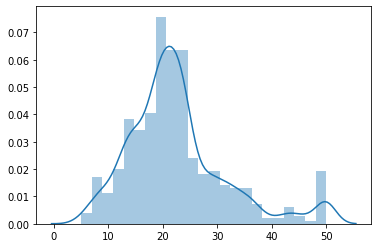

In [ ]:
sns.distplot(boston.target)

Sprawdźmy też korelacje - zgodnie z założeniami regresji liniowej z wykładu silnie skorelowane cechy są bardzo niekorzystne dla tego algorytmu.

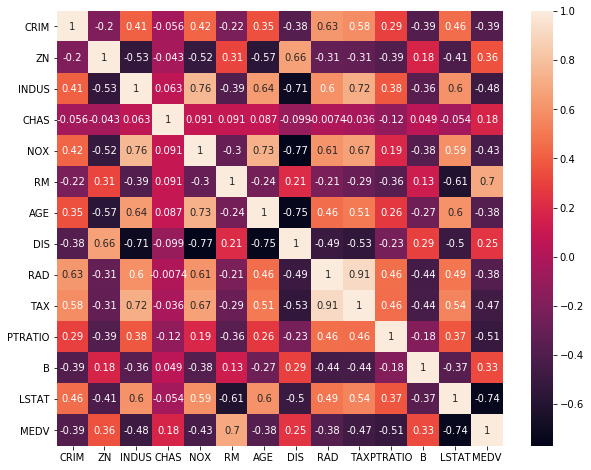

In [ ]:
fig, ax = plt.subplots(figsize=(10., 8.))
sns.heatmap(ax=ax, data=boston_df.corr(), annot=True)

Na szczęście nie ma tu na ogół bardzo mocnych korelacji, poza zmiennymi RAD i TAX - są to odpowiednio dostęp do autostrad i podatek. Na pierwszy rzut oka nie widać, czemu korelacja tych cech miałaby być tak wysoka (może lokalizacje działek niedaleko wjazdów na autostrady są na ogół na cenniejszych gruntach z wyższym podatkiem?), ale tak się zdarza. Warto na to potem zwrócić uwagę.

Podzielmy teraz nasze dane na zbiory treningowy i testowy oraz je ustandaryzujmy.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.3, random_state=0)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_rescaled = scaler.transform(X_train)
X_test_rescaled = scaler.transform(X_test)

## Zwykła regresja

Przypomnijmy sobie, że regresor `LinearRegression()` ze Scikit-learn'a ma 4 ważne hiperparametry:

1) `fit_intercept=True` - czy mamy wyraz wolny (bias, intercept), czy nie; jeżeli nasze dane są wycentrowane (mają wartość średnią 0), to powinniśmy dać False, żeby prosta przechodziła przez środek naszej chmury punktów

2) `normalize=False` - (ignorowane, gdy `fit_intercept=False`) gdy ma wartość `True`, to dokonamy normalizacji (odjęcia wartości średniej, znormalizowania wektorów kolumnowych cech dzieląc je przez ich długość) - tego rodzaju, o którym mówiliśmy na ostatnim wykładzie

3) `copy_X=True` - czy kopiować macierz `X`; jest to koszt pamięciowy, ale dla `False` macierz może zostać nadpisana dla wydajności (np. przy normalizacji), przez co stracimy oryginalne dane

4) `n_jobs=None` - ile rdzeni wykorzystać do obliczeń, regresja liniowa w wersjach różniczkowalnych (zwykła i L2) dobrze się uwspółbieżnia dzięki wykorzystaniu macierzy; typowo ustawiamy -1 (wszystkie rdzenie)

In [ ]:
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(X_train_rescaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Tym razem nie będziemy już ręcznie liczyć metryk jak w poprzednim notebooku, tylko skorzystamy z wbudowanych funkcji Scikit-learn'a, które efektywnie robią pod spodem to samo, ale są czytelniejsze i krósze w zapisie. Są to:

- `mean_absolute_error()` - błąd MAE, przyjmuje argumenty `y_true` i `y_pred`
- `mean_squared_error()` - błąd MSE lub RMSE, zależy to od argumentu `squared` (dla `True` - MSE, dla `False` - RMSE, domyślnie `True`); jak chcemy dostać RSS, to musimy policzyć MSE i pomnożyć przez liczbę przykładów `n`; poza tym przyjmuje argumenty `y_true` i `y_pred`

In [ ]:
y_pred = linear_model.predict(X_test_rescaled)
n = X_test_rescaled.shape[0]

print(f"RSS: {n * mean_squared_error(y_test, y_pred, squared=True)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

RSS: 4133.786796566247
RMSE: 5.214975145375403
MAE: 3.6099040603818127


Wypiszmy współczynniki dla poszczególnych cech, budując pomocniczy DataFrame:

In [ ]:
print(f"Intercept: {linear_model.intercept_}")
coeff_names = boston_df.keys().drop(["MEDV"])  # remove target column from names - it does not have a coefficient

coeff_df = pd.DataFrame(linear_model.coef_, coeff_names, columns=["Coefficient"])
coeff_df

Intercept: 22.745480225988754


,Coefficient
CRIM,-1.011901
ZN,1.050280
INDUS,0.079210
CHAS,0.618962
NOX,-1.873691
RM,2.705270
AGE,-0.279573
DIS,-3.097665
RAD,2.096900
TAX,-1.886063


Współczynniki nie są zbyt duże - to znak, że jest całkiem nieźle. Warto jednak zwrócić uwagę, że np. waga cechy INDUS (ilość biznesów nie-usługowych, czyli industrialnych) jest bardzo mała - być może warto byłoby się jej pozbyć?

Kiedy wrócimy wyżej do macierzy z korelacjami i spojrzymy na korelację cechy INDUS z innymi, to ma dość mocne korelacje z cechami NOX (zanieczyszczenie powietrza) i AGE (liczba starych budynków). Skoro sama cecha INDUS jest mało warta, to być może te też? Sama cecha AGE też ma dość niewielką wagę, NOX już sporą, ale może to być mylny wynik, skoro mamy korelacje.

Przeanalizujmy teraz relację między wynikami naszego modelu a prawdziwymi wartościami. Z założeń regresji liniowej wiemy, że nie powinno być tu mocnych korelacji.

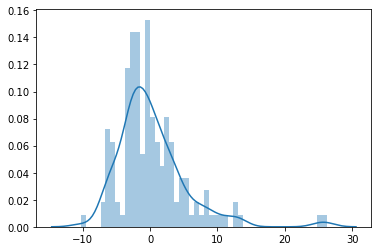

In [ ]:
sns.distplot(y_test - y_pred, bins=50)

Jak widać, mamy rozkład w miarę zbliżony do normalnego, z mocnymi tendencjami do wartości średniej 0. To dobry znak - nasz regresor nieźle sobie radzi.

### Zadanie 1 - feature engineering

Dokonaj ręcznego feature engineeringu na podstawie dotychczasowych obserwacji. Usuń cechę INDUS i sprawdź, czy metryki są lepsze (na zbiorze testowym). Następnie usuń także cechę AGE, a potem też NOX - jak zmieniają się wyniki? Czy nasze podejrzenia okazały się słuszne?

Przydatna będzie metoda `.drop()` DataFrame'ów z Pandasa - [link do dokumentacji](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

## Regresja wielomianowa

Użyjemy tutaj `PolynomialFeatures()`, aby wygenerować feature'y do stopnia 2 włącznie, co w połączeniu z `LinearRegression()` da regresję wielomianową.

Ważne argumenty `PolynomialFeatures()`:

1) `degree=2` - stopień wielomianu, który nas interesuje; wartość domyślna 2 daje sporo dodatkowych cech, ale jeszcze rozsądną liczbę

2) `interaction_only=False` - czy generować wszystkie cechy, czy tylko interakcje między zmiennymi (iloczyny kolumn)?

3) `include_bias=True` - czy dodawać explicite kolumnę samych 1, czyli bias? Jeżeli planujemy potem korzystać z modelu, który ma własny bias "wbudowany" (np. regresja liniowa), to trzeba ustawić False

In [ ]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_poly_rescaled = scaler.transform(X_train_poly)
X_test_poly_rescaled = scaler.transform(X_test_poly)

In [ ]:
print(f"Previous number of features: {X_train_rescaled.shape[1]}")
print(f"Current number of features: {X_train_poly_rescaled.shape[1]}")

Previous number of features: 13
Current number of features: 104


In [ ]:
polynomial_model = LinearRegression(n_jobs=-1)
polynomial_model.fit(X_train_poly_rescaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
y_pred = polynomial_model.predict(X_test_poly_rescaled)
n = X_test_poly_rescaled.shape[0]

print(f"RSS: {n * mean_squared_error(y_test, y_pred, squared=True)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

RSS: 4446.3810851582875
RMSE: 5.408558693330346
MAE: 3.0519674972920408


Według metryk RSS i RMSE radzimy sobie gorzej, według metryki MAE - lepiej. Może się zdarzyć, że będzie nam gorzej szło, bo znacznie zwiększyliśmy liczbę wymiarów i klątwa wymiarowości odciska tu swoje piętno. Fakt, że metryka MAE jest mniejsza, jest jednak bardzo ciekawy - potencjalnie mamy tu jakieś outliery, które dodatkowe feature'y mocniej uwydatniły, przez co RMSE wzrosło, a jednak bardziej "bezpośrednie" dopasowanie liczone wartością bezwzględną jest dokładniejsze.

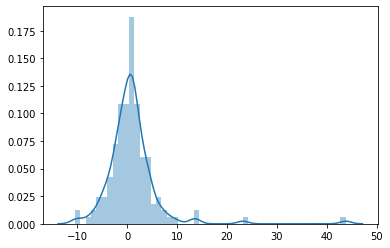

In [ ]:
sns.distplot(y_test - y_pred, bins=50)

Porównajmy powyższy wykres z odpowiadającym mu wykresem dla zwykłej regresji. Możemy zauważyć, że wartości przewidziane przez regresję wielomianową na zbiorze testowym są dużo bardziej "zbite" wokół średniej wartości 0 i dużo mocniej przypominają rozkład normalny. Faktycznie jest to więc lepsze dopasowanie niż w przypadku zwykłej regresji.

### Zadanie 2 - tylko interakcje

Na wykładzie powiedzieliśmy, że same feature'y interakcji są często najważniejsze, bo podnoszenie oryginalnych cech do potęgi jest mało sensowne. Popatrz na cechy zbioru Boston Housing i zastanów się, czy jest sens dokonywać takiego obliczenia. Wypróbuj następnie generowanie cech tylko dla cech-interakcji i sprawdź, czy wyniki są lepsze (na zbiorze testowym).

## Ridge regression - sztuczny przykład w 2D

W regresji grzbietowej minimalizujemy funkcję:
$$C(w) = ||y - \hat{y}||^2_2 + \alpha ||w||_2^2$$

W tej części tak jak ostatnio wygenerujemy dane według równania $$y = 2x+1 + \varepsilon $$ Dla utrudnienia zadania dodamy jednak widocznie odstającego outliera. Porównamy, jak z dopasowaniem prostej poradzi sobie nieregularyzowana i regularyzowana (L2) regresja liniowa.


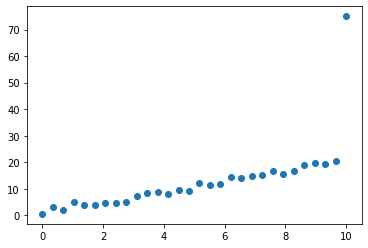

In [ ]:
n_points = 30
x = np.linspace(0, 10, num=n_points).reshape(n_points, 1)
y = 2. * x + 1 + np.random.normal(size=(n_points, 1), scale=1)
y[-1] = 75

plt.scatter(x, y)

In [ ]:
simple_linear_model = LinearRegression()
simple_linear_model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Dokładny opis regresora `Ridge` jest niżej, przy sekcji Boston Housing. Tutaj ważne jest tylko, że siła regularyzacji jest oznaczana jako `alpha` (zamiast lambdy jak na wykładzie) - wybieramy jakąś wartość i próbujemy.

In [ ]:
alpha = 150
simple_ridge_model = Ridge(alpha=alpha)
simple_ridge_model.fit(x, y)

Ridge(alpha=150, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

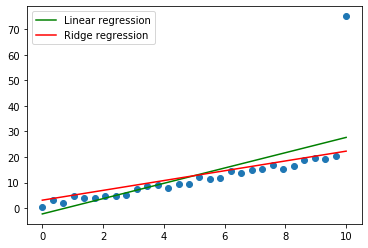

In [ ]:
plt.scatter(x, y)
plt.plot(x, simple_linear_model.predict(x), color="green", label='Linear regression')
plt.plot(x, simple_ridge_model.predict(x), color="red", label='Ridge regression')
plt.legend()

Jak widać ridge regression poradziło sobie o wiele lepiej. Wynika to z tego, że zmniejszyła wagę naszej jedynej cechy, czyli współczynnik kierunkowy tej prostej. Co jednak, gdy realnie chcielibyśmy wyższy współczynnik, a nie niższy?

### Zadanie 3 - pechowe outliery

Dodaj outlier jako punkt o dużej wartości na początku, a nie na końcu danych wygenerowanych analogicznie jak w poprzednim przykładzie. Spróbuj następnie wygenerować zarówno linię dla zwykłej regresji, jak i ridge regression dla $\lambda$ z wartościami 10, 100 i 1000. Czy ridge regression radzi sobie lepiej? Z jak silną regularyzacją najlepiej zaczynać podejście do regresji - w ogóle bez, słabą czy silną?

## Ridge regression - Boston Housing dataset

Teraz wykorzystamy regresor `Ridge` dla regularyzowanej regresji liniowej dla naszego zbioru danych.

Najważniejsze argumenty `Ridge`:

1) `alpha=1` - siła regularyzacji

2) `fit_intercept=True` - czy dodawać wyraz wolny (bias, intercept)? Dla danych wycentrowanych ustawiamy na `False`

3) `normalize=False` - czy normalizować dane? Normalizacja tutaj jest w takim sensie, jak na wykładzie, tj. usuwa wartość średnią z każdej kolumny i dzieli ją przez jej długość, normalizując ją do 1

4) `copy_X=True` - czy kopiować macierz X? Jeżeli jest `False`, to przekazana do treningu macierz `X` może zostać nadpisana dla wydajności

5) `max_iter=None`, `tol=1e-3` - parametry kontrolujące koniec iteracji dla solwerów iteracyjnych (zakładamy, że skończyliśmy optymalizować, gdy którykolwiek z warunków będzie osiągnięty); dla solwerów nie-iteracyjnych (np. "svd") znaczenie ma tylko `tol`, bo wyznacza precyzję rozwiązania

6) `solver="auto"` - rodzaj algorytmu (solwera) do użycia; jeżeli nie mamy jakichś wyraźnych potrzeb, to opcja `"auto"` sprawdza się bardzo dobrze, bo Scikit-learn sprawdza nasze dane i na ich podstawie stara się dobrać optymalny algorytm

7) `random_state=None` - jeżeli używamy solwera z elementami pseudolosowymi (SAG lub SAGA), to ustawiamy tu jakąś liczbę dla powtarzalności wyników

Zróbmy przykładowe ridge regression dla słabej regularyzacji i zobaczmy, jakie nam wyjdą metryki.

In [ ]:
alpha = 10
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_rescaled, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred = ridge_model.predict(X_test_rescaled)
n = X_test_rescaled.shape[0]

print(f"RSS: {n * mean_squared_error(y_test, y_pred, squared=True)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

RSS: 4208.683108279318
RMSE: 5.262005763939484
MAE: 3.6083150932386863


Nie jest za dobrze - wyniki są lekko gorsze niż dla zwykłej regresji, a dużo gorsze niż dla wielomianowej. Może jednak nasza regularyzacja jest zbyt słaba? Sprawdźmy współczynniki dla poszczególnych cech.

In [ ]:
print(f"Intercept: {ridge_model.intercept_}")
coeff_names = boston_df.keys().drop(["MEDV"])  # remove target column from names - it does not have a coefficient

coeff_df = pd.DataFrame(ridge_model.coef_, coeff_names, columns=["Coefficient"])
coeff_df

Intercept: 22.745480225988754


,Coefficient
CRIM,-0.933398
ZN,0.901779
INDUS,-0.130099
CHAS,0.653141
NOX,-1.554675
RM,2.780153
AGE,-0.318141
DIS,-2.751812
RAD,1.470846
TAX,-1.327215


Faktycznie wartości współczynników niewiele się zmieniły, więc nasza regularyzacja jest dość słaba. Może więc silniejsza regularyzacja bardziej pomoże?

### Zadanie 4 - wpływ regularyzacji L2 na wyniki

Stwórz wykres zależności wybranej metryki (np. RMSE lub MAE, bo są małe i czytelne) od współczynnika siły regularyzacji `alpha`. Metrykę mierzymy na zbiorze  Wypróbuj wartości od braku (`alpha=0`) do dość mocnej (`alpha=1000`) z krokiem np. 10 (jeżeli moc obliczeniowa na to nie pozwoli, to np. krok 50). Wykonaj to na zbiorze testowym - dzięki temu faktycznie znajdziemy optymalną siłę regularyzacji dla tego zbioru. Czy nasze podejrzenie zbyt słabej regularyzacji okazało się słuszne?

### Zadanie 5 - optymalizacja z `GridSearchCV`

Wypróbuj [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) dla optymalizacji współczynnika `alpha`. Dzięki temu obiektowi automatycznie zostanie wykonana walidacja skrośna (a zatem i generowanie kolejnych zbiorów walidacyjnych i uśrednianie wyników), jak i sprawdzenie po kolei przekazanych wartości hiperparametrów.

Wygeneruj takie same współczynniki `alpha`, jak w zadaniu 4, czyli np. listę z elementami od 0 do 1000 włącznie co 10. Twój estymator to po prostu `Ridge()` (`GridSearchCV` potem sam ustawi odpowiednie hiperparametry), `param_grid` to słownik z tylko jednym kluczem `alpha` i wartością będącą przygotowaną listą wartości. Pamiętaj o ustawieniu `n_jobs=-1`, aby wykorzystać wszystkie rdzenie procesora - optymalizacja `GridSearchCV` jest uwspółbieżnialna praktycznie w 100%.

Na koniec w obiekcie `GridSearchCV` w atrybucie `best_estimator_` znajduje się nasz ridge regressor z najlepszymi wynikami, a w słowniku `best_params_` optymalne wartości hiperparametrów. Sprawdź, czy wyniki (metryka ta sama co w zadaniu 4 i wartość `alpha`) zgadzają się z zadaniem 4.

### Zadanie 6 - wagi po regularyzacji

Dla najlepszego estymatora wyznaczonego w poprzednim zadaniu sprawdź wagi współczynników, podobnie jak w pokazanych wcześniej przykładach. Czy są mniejsze niż dla wybranego dość losowo `alpha=10`?

## Lasso regression - sztuczny przykład w 2D

Dla przypomnienia, w regresji lasso minimalizujemy funkcję:
$$C(w) = ||y - \hat{y}||^2_2 + \alpha ||w||_1$$

#### Sztuczny przykład w 2D

... brak przykładu!

### Zadanie 7 - regresja lasso dla 1 zmiennej

Czemu regresja lasso dla 1 zmiennej nie ma za bardzo sensu?

_Swoją odpowiedź możesz zapisać tutaj_

## Lasso regression - Boston Housing dataset

Wyróbujmy teraz lasso regression na zbiorze danych. Zmiennych jest tu sporo, jak podejrzewamy niektóre z nich są niepotrzebne, więc faktycznie LASSO może nam pomóc z automatycznym feature selection.

Ważne argumenty regresora `Lasso`:

1) `alpha=1`, `fit_intercept=True`, `normalize=False`, `copy_X=True` - dokładnie tak jak wcześniej

2) `max_iter=1000`, `tol=1e-4` - analogicznie jak wcześniej kontroluje warunek końca iteracji; w przypadku regresji LASSO używany algorytm coordinate descent jest iteracyjny, więc tutaj te współczynniki mają często znaczenie

3) `positive=False` - kiedy jest `True`, to wymuszamy nieujemne wartości współczynników; jest to sensowne, gdy z natury problemu oczekujemy, że nasze cechy będą tylko zwiększać trend regresji, np. w ekonomii (gdy wiemy z pewnych praw i teorii, że tak powinno być)

4) `random_state` - szczególnie ważne, żeby je ustawić, bo coordinate descent zaczyna z pseudolosowego miejsca, wyznaczanego przez tę liczbę

5) `selection="cyclic"` - albo `"cyclic"`, albo `"random"`, steruje zachowaniem coordinate descentu; według dokumentacji `"random"` może być często szybkie, szczególnie dla dość dużej toleracji (`> 1e-4`)

In [ ]:
alpha = 1
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_rescaled, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [ ]:
y_pred = lasso_model.predict(X_test_rescaled)
n = X_test_rescaled.shape[0]

print(f"RSS: {n * mean_squared_error(y_test, y_pred, squared=True)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

RSS: 5063.247507807563
RMSE: 5.771554285212521
MAE: 3.957998413357712


Błędy są dość wysokie - może usunęliśmy za dużo / za mało cech?

In [ ]:
print(f"Intercept: {lasso_model.intercept_}")
coeff_names = boston_df.keys().drop(["MEDV"])  # remove target column from names - it does not have a coefficient

coeff_df = pd.DataFrame(lasso_model.coef_, coeff_names, columns=["Coefficient"])
coeff_df

Intercept: 22.74548022598875


,Coefficient
CRIM,-0.034090
ZN,0.000000
INDUS,-0.000000
CHAS,0.000000
NOX,-0.000000
RM,2.675475
AGE,-0.000000
DIS,-0.000000
RAD,-0.000000
TAX,-0.119743


Co prawda 13 cech to sporo, ale usunięcie aż 7 z nich i zmniejszenie wagi ósmego prawie do 0 to chyba jednak przesada. Jak widać, dla regresji lasso wartość współczynnika `alpha` powinna być raczej bardzo mała. Ale jaka dokładnie?

### Zadanie 8 - hiperparametry z przestrzeni ciągłych

Znajdź optymalną wartość współczynnika `alpha` dla regresji lasso. Zauważ przy tym, że interesują nas ułamkowe wartości, więc zwykłe generowanie listy z Pythona nie wystarczy. Za to Numpy ma funkcję `np.linspace()`, która pozwala wygenerować listę równomiernie rozłożonych wartości z określonego zakresu, przy czym mogą to być też liczby zmiennoprzecinkowe. Efektywnie tworzy to dyskretny jednostajny rozkład prawdopodobieństwa.

Ważne argumenty funkcji `np.linspace()` to `start`, `stop`, `endpoint`, `num` i `retstep`. Dla `endpoint=False` generujemy w zakresie `[start, stop)`, natomiast dla `endpoint=True` w zakresie `[start, stop]` (i koniec zawsze jest dołączany do wygenerowanego zakresu jako ostatni punkt). Możemy wybrać albo liczbę punktów do wygenerowania za pomocą `num`, albo krok `retstep` co jaką odległość będziemy generować - korzystamy z tego, co jest akurat wygodniejsze, można w końcu łatwo przeliczyć jedno na drugie i vice versa.

Skoro mamy tutaj dyskretny rozkład prawdopodobieństwa, to może być potrzeba przeszukać sporo opcji, a `GridSearchCV` może być dość wolny. Zamiat tego możemy wykorzystać `RandomizedSearchCV` z odpowiednią liczbą `n_iter`, czyli prób, np. 100.

Stwórz `np.linspace()` z `num=10000`. Sprawdź metryki oraz czasy wykonania dla `n_iter` z listy `[10, 100, 1000]` - jak zachowują się jakość i czas? Do mierzenia czasu użyj funkcji `time` z modułu wbudowanego `time`.

Jaka wartość `alpha` jest optymalna (według `GridSearchCV`)? Ile cech jest "wyzerowanych"? Które to cechy? Czy nasze wcześniejsze podejrzenia okazały się słuszne?

### Zadanie 9* - próbkowanie z rozkładów prawdopodobieństwa

To zadanie możesz potraktować jako trochę dodatkowe.

Kiedy wiemy, że raczej interesują nas małe wartości, to lepiej wykorzystać rozkład log-normalny, a nie jednostajny czy normalny. Rozkład ten silnie faworyzuje mniejsze wartości, patrz np. [wykresy stąd](https://scikit-learn.org/0.22/auto_examples/compose/plot_transformed_target.html). `RandomizedSearchCV` musi dostać albo listę, albo rozkład prawdopodobieństwa z Numpy'a / Scipy'a, który może próbkować (metoda `.rvs()`), dlatego można użyć rozkładu log-normal. Można oczywiście też po prostu wygenerować listę z elementami z rozkładu i taką listę przekazać - efektywnie będzie to praktycznie to samo.

Stwórz rozkład log-normal i z użyciem jego i `RandomizedSearchCV` zoptymalizuj regresję Lasso. Możesz albo wykorzystać Scipy'a i jego rozkład prawdopodobieństwa `sp.stats.lognorm()`, albo wygenerować listę elementów Numpy'em i jego funkcją `np.random.lognormal()`. Czy w ten sposób wystarczy mniej prób `n_iter`, aby osiągnąć zadowalające rezultaty?

## ElasticNet regression - Boston Housing dataset

W regresji ElasticNet minimalizujemy funkcję będącą połączeniem regularyzacji L2 i L1:
$$C(w) = ||y - \hat{y}||^2_2 + \alpha ||w||_2^2 + \beta ||w||_1$$

W Scikit-learn'ie obiekt `ElasticNet` jest dość dziwny pod względem siły regularyzacji, bo optymalizuje on (wbrew typowej konwencji z wykładu) funkcję:
$$C(w) = \frac{1}{2 * \text{n_samples}}||y - \hat{y}||^2_2 + 0.5 * \alpha * (1 - \text{l1_ratio}) * ||w||_2^2 $$
$$+ \alpha * \text{l1_ratio} * ||w||_1$$

Idea twórców jest taka, że sterujemy poniekąd połączoną siłą regularyzacji: `alpha` wyznacza ogólną siłę regularyzacji, a `l1_ratio` jak dużo z tej regularyzacji to L1 (reszta to L2). Można to przeliczyć na osobne współczynniki dla L1 i L2:

`a * L1 + b * L2`

`alpha = a + b`

`l1_ratio = a / (a + b)`

Mamy tutaj tak czy tak 2 hiperparametry do optymalizacji, przy czym większe `l1_ratio` to większe skupienie na feature selection, a mniejsze to większe skupienie na redukcji wag.

Pozostałe ważne argumenty są analogiczne do regresji ridge i lasso. Ważną informacją jest, że wykorzystujemy tutaj iteracyjny algorytm coordinate descent, więc mamy argumenty `selection`, `max_iter` i `tol`.

## Zadanie 10 - wielki finał

Udało ci się dotrzeć do samego końca! Teraz możemy w końcu połączyć wszystko, co sprawdziliśmy wyżej, w naprawdę solidny regresor dla problemu wyceny domów.

Postaraj się uzyskać optymalne metryki dla zbioru Boston Housing, korzystając z technik z tego notebooka:
- standaryzacja (`StandardScaler`) oraz normalizacja (`sklearn.preprocessing.normalize()`) cech
- stworzenie dodatkowych cech za pomocą `PolynomialFeatures`, być może samych interakcji
- wykorzystanie zarówno regularyzacji L2, jak i L1 dzięki `ElasticNet`
- optymalizacja hiperparametrów za pomocą `GridSearchCV` lub `RandomizedSearch`

Zbiór ten jest bardzo popularny i uzyskanie na nim dobrego wyniku za pomocą tych podstawowych technik świadczy o solidnej znajomości podstaw ML. W związku z tym w internecie można też znaleźć mnóstwo sztuczek, jak uzyskać lepsze wyniki, np. w ramach feature engineeringu zmienić rozkład jakiejś cechy jak w [tym przykładzie](https://scikit-learn.org/0.22/auto_examples/compose/plot_transformed_target.html), aby był bliższy rozkładowi normalnemu.

Powodzenia!

### Zadanie dodatkowe

W bibliotece Scikit-optimize (`skopt`) jest bardzo ciekawy i wydajny optymalizator, `BayesSearchCV` ([dokumentacja i przykład użycia](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV)). Możesz spróbować skorzystać z niego zamiast innych form CV - działa to zasadniczo jak inteligentne `RandomizedSearchCV` z bardzo łatwym definiowaniem rozkładów prawdopodobieństwa (patrz podlinkowany przykład - wystarczy napisać np. `prior='log-uniform'` i stworzy to rozkład log-jednostajny). Możesz spróbować tego użyć, aby przyspieszyć optymalizację hiperparametrów w zadaniu 10.

## Zadanie domowe

Jako dodatkowe zadanie domowe możesz zaimplementować ridge regression i/lub lasso regression. Do ridge regression możesz użyć GD lub CD, a dla lasso CD. Jeżeli masz naprawdę nadmiar czasu, to możesz też zaimplementować ElasticNet za pomocą CD.